# Training the Cellvit Model

#### Getting the data ready

source /opt/conda/bin/activate tissuevit

pip uninstall -y flash-attn torch torchvision torchaudio xformers && pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 && pip install flash-attn --no-build-isolation --no-cache-dir && pip install xformers --index-url https://download.pytorch.org/whl/cu124

pip install torch==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

In [1]:
import sys
import os

# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2. Add the project root to the list of places Python looks for modules
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print("OKK")

OKK


In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models.orion_dataset import OrionImageFeeder
from src.utils.plot_utils import visualize_multichannel_image

print("Imports OK")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.5.1+cu124)
    Python  3.12.9 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2025-12-01 13:01:13.071 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues
2025-12-01 13:01:13.071 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues


Imports OK


In [3]:
# Initialize the Feeder
# This handles config loading, dataset building, and model initialization internally
feeder = OrionImageFeeder()

# Get all available Tissue IDs
all_tids = feeder.get_all_tids()
print(f"Total available tissues: {len(all_tids)}")

# Select a subset for this run (e.g., first 20)
selected_tids = all_tids[:20]
print(f"Selected {len(selected_tids)} tissues for processing.")

/data/code/jon/project-2-gradient_tri_scent/src/utils/marker_utils.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(os.path.join(embedding_d

2025-12-01 13:01:14.974 | INFO     | src.dataset.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_log exists
/data/code/jon/project-2-gradient_tri_scent/src/dataset/datasets/multiplex_base.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.channels_per_image.fillna(1, inplace=True)
/data/code/jon/project-2-gradient_tri_scent/src/dataset/datasets/multiplex_base.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.channels_per_image = self.channels_p

Initializing OrionImageFeeder...
Building MM Datasets...


2025-12-01 13:01:15.207 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:128 - Using protein embedding: esm with shape torch.Size([213, 640])
2025-12-01 13:01:15.210 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add
2025-12-01 13:01:15.210 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add


Label Encoder loaded: ['None' 'Stroma' 'Endothelia' 'Macrophage' 'Tumor' 'Helper T cell'
 'Cytotoxic T cell' 'Other' 'Treg' 'B cells']
Initializing VirTues Encoder...
VirTues Encoder initialized and weights loaded.
Total available tissues: 35
Selected 20 tissues for processing.
VirTues Encoder initialized and weights loaded.
Total available tissues: 35
Selected 20 tissues for processing.


In [4]:
import torch.optim as optim
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score, calculate_f1_score

# 1. Data Split
# Shuffle TIDs for random split
np.random.seed(42)
shuffled_tids = np.array(all_tids)
np.random.shuffle(shuffled_tids)

n_total = len(shuffled_tids)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_test = n_total - n_train - n_val

train_tids = shuffled_tids[:n_train]
val_tids = shuffled_tids[n_train:n_train+n_val]
test_tids = shuffled_tids[n_train+n_val:]

print(f"Split: Train={len(train_tids)}, Val={len(val_tids)}, Test={len(test_tids)}")

# 2. Model Setup
# Determine number of classes
if feeder.label_encoder is not None:
    num_classes = len(feeder.label_encoder)
    print(f"Number of classes from encoder: {num_classes}")
    print(f"Classes: {feeder.label_encoder}")
else:
    num_classes = 6 # Default fallback
    print(f"Warning: Using default num_classes={num_classes}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Decoder
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, # VirTues output dim
    drop_rate=0.1
).to(device)

# Optimizer
optimizer = optim.AdamW(decoder.parameters(), lr=1e-4, weight_decay=1e-2)

# Loss Function
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5)

print("Model, Optimizer, and Loss initialized.")

Split: Train=24, Val=5, Test=6
Number of classes from encoder: 10
Classes: ['None' 'Stroma' 'Endothelia' 'Macrophage' 'Tumor' 'Helper T cell'
 'Cytotoxic T cell' 'Other' 'Treg' 'B cells']
Model, Optimizer, and Loss initialized.
Model, Optimizer, and Loss initialized.


In [5]:
def visualize_image(orig_img, orig_mask, tid, channels):
    print("\n--- Visualization for First Image ---")
    
    # 1. Original Image
    # orig_img might be a Tensor, convert to numpy for visualization
    if isinstance(orig_img, torch.Tensor):
        orig_img_vis = orig_img.cpu().numpy()
    else:
        orig_img_vis = orig_img
        
    print(f"Original Image Shape: {orig_img_vis.shape}")
    visualize_multichannel_image(orig_img_vis, title=f"Tissue {tid}")
    plt.show()
    
    # 2. Ground Truth Mask
    print(f"Original Mask Shape: {orig_mask.shape}")
    plt.figure(figsize=(6, 6))
    plt.imshow(orig_mask, cmap='tab20', interpolation='nearest')
    plt.title(f"Ground Truth Mask {tid}")
    plt.colorbar()
    plt.show()
    
    # 3. Print Channel Names
    # We can map channel indices to names using the feeder's dictionary
    channel_names = [feeder.uniprot_to_name.get(c, f"Unknown-{c}") for c in channels]
    print(f"Channels: {channel_names}")
    

## Test Training


--- Starting Overfit Sanity Check (Cached Data) ---
Overfitting on tissue: orion_dforbase_0
Processing tissue 1/1: orion_dforbase_0
Processing tissue 1/1: orion_dforbase_0
Data loaded. PSS: torch.Size([1, 32, 32, 512]), Mask: torch.Size([1, 256, 256])

Testing LR: 0.001
Data loaded. PSS: torch.Size([1, 32, 32, 512]), Mask: torch.Size([1, 256, 256])

Testing LR: 0.001
  Epoch 50: 0.8033
  Epoch 50: 0.8033
  Epoch 100: 0.5082
  Epoch 100: 0.5082
  Epoch 150: 0.2528
  Epoch 150: 0.2528
  Epoch 200: 0.1414
  Epoch 200: 0.1414
  Epoch 250: 0.1039
  Epoch 250: 0.1039
  Epoch 300: 0.0843

Testing LR: 0.0005
  Epoch 300: 0.0843

Testing LR: 0.0005
  Epoch 50: 0.9039
  Epoch 50: 0.9039
  Epoch 100: 0.6067
  Epoch 100: 0.6067
  Epoch 150: 0.3558
  Epoch 150: 0.3558
  Epoch 200: 0.2214
  Epoch 200: 0.2214
  Epoch 250: 0.1483
  Epoch 250: 0.1483
  Epoch 300: 0.1076

Testing LR: 0.0001
  Epoch 300: 0.1076

Testing LR: 0.0001
  Epoch 50: 1.2315
  Epoch 50: 1.2315
  Epoch 100: 0.9747
  Epoch 100: 0.9

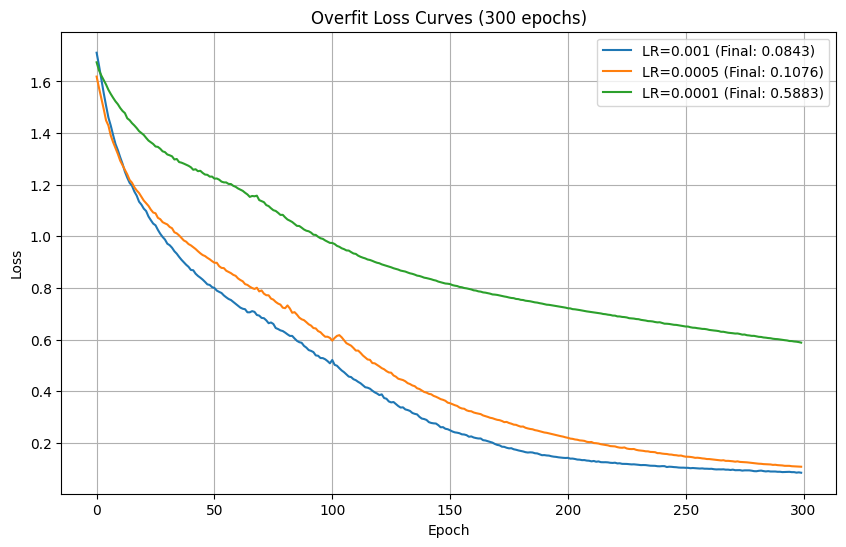

Best LR: 0.001


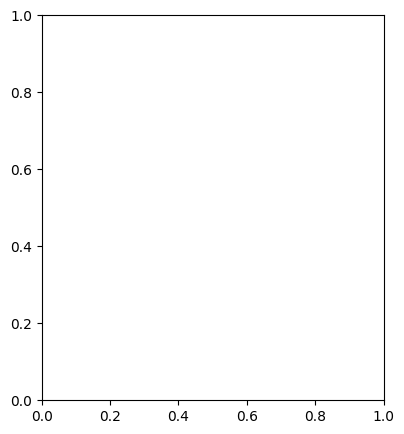

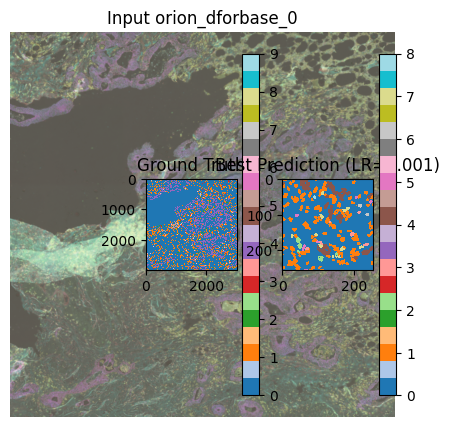

Updated main 'decoder' with best weights.


In [8]:
# Overfit Sanity Check - Hyperparameter Sweep
print("--- Starting Overfit Sanity Check (Cached Data) ---")

# 1. Pick ONE Tissue and Load it ONCE
if 'train_tids' not in locals():
    # Fallback if not defined
    all_tids = feeder.get_all_tids()
    train_tids = all_tids[:1]

single_tid = [train_tids[0]]
print(f"Overfitting on tissue: {single_tid[0]}")

# Fetch data once
data_gen = feeder.iterate_image_orion(single_tid, crop_size=256)
data_dict = next(data_gen) 

# Move to GPU
pss = data_dict['pss'].to(device)
mask = data_dict['mask'].to(device).long()
orig_img = data_dict['original_image']
orig_mask = data_dict['original_mask']

print(f"Data loaded. PSS: {pss.shape}, Mask: {mask.shape}")

# 2. Experiment Setup
learning_rates = [1e-3, 5e-4, 1e-4]
num_epochs = 300
results = {}

for lr in learning_rates:
    print(f"\nTesting LR: {lr}")
    
    # Re-initialize model to start fresh
    # We need to ensure we use the same config as before
    temp_decoder = CellViTDecoder(
        num_nuclei_classes=num_classes,
        embed_dim=512, 
        drop_rate=0.1
    ).to(device)
    
    optimizer = optim.AdamW(temp_decoder.parameters(), lr=lr, weight_decay=1e-2)
    temp_decoder.train()
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = temp_decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}: {loss.item():.4f}")
            
    results[lr] = {
        'losses': losses,
        'final_loss': losses[-1],
        'model': temp_decoder # Keep reference to visualize best
    }

# 3. Plot Loss Curves
plt.figure(figsize=(10, 6))
for lr, res in results.items():
    plt.plot(res['losses'], label=f"LR={lr} (Final: {res['final_loss']:.4f})")
plt.title(f"Overfit Loss Curves ({num_epochs} epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 4. Visualize Best Result
best_lr = min(results, key=lambda k: results[k]['final_loss'])
print(f"Best LR: {best_lr}")
best_decoder = results[best_lr]['model']
best_decoder.eval()

with torch.no_grad():
    outputs = best_decoder(pss)
    pred_logits = outputs['nuclei_type_map']
    pred_mask = torch.argmax(pred_logits, dim=1).cpu().numpy()[0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
img_vis = orig_img if not isinstance(orig_img, torch.Tensor) else orig_img.cpu().numpy()
visualize_multichannel_image(img_vis, title=f"Input {single_tid[0]}")

plt.subplot(1, 3, 2)
plt.imshow(orig_mask, cmap='tab20', interpolation='nearest')
plt.title("Ground Truth")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='tab20', interpolation='nearest')
plt.title(f"Best Prediction (LR={best_lr})")
plt.colorbar()
plt.show()

# Update the main decoder with the best weights for subsequent cells
decoder.load_state_dict(best_decoder.state_dict())
print("Updated main 'decoder' with best weights.")

## Acual Training here

--- Starting Full Training Run (300 Epochs) ---


/data/code/jon/project-2-gradient_tri_scent/src/models/orion_dataset.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mx_image = torch.tensor(tissue).cuda(non_blocking=True).unsqueeze(0) # (1, C, H, W)


Epoch 1/50 | Train Loss: 1.4050 | Val Loss: 1.2330 | Val Dice: 0.4846
  --> New best model saved (Val Loss: 1.2330)
  --> New best model saved (Val Loss: 1.2330)
Epoch 2/50 | Train Loss: 1.1511 | Val Loss: 0.8918 | Val Dice: 0.4847
Epoch 2/50 | Train Loss: 1.1511 | Val Loss: 0.8918 | Val Dice: 0.4847
  --> New best model saved (Val Loss: 0.8918)
  --> New best model saved (Val Loss: 0.8918)
Epoch 3/50 | Train Loss: 1.0568 | Val Loss: 0.8858 | Val Dice: 0.4879
Epoch 3/50 | Train Loss: 1.0568 | Val Loss: 0.8858 | Val Dice: 0.4879
  --> New best model saved (Val Loss: 0.8858)
  --> New best model saved (Val Loss: 0.8858)
Epoch 4/50 | Train Loss: 1.0113 | Val Loss: 0.8744 | Val Dice: 0.4956
Epoch 4/50 | Train Loss: 1.0113 | Val Loss: 0.8744 | Val Dice: 0.4956
  --> New best model saved (Val Loss: 0.8744)
  --> New best model saved (Val Loss: 0.8744)
Epoch 5/50 | Train Loss: 0.9969 | Val Loss: 0.9158 | Val Dice: 0.4540
Epoch 5/50 | Train Loss: 0.9969 | Val Loss: 0.9158 | Val Dice: 0.4540
Ep

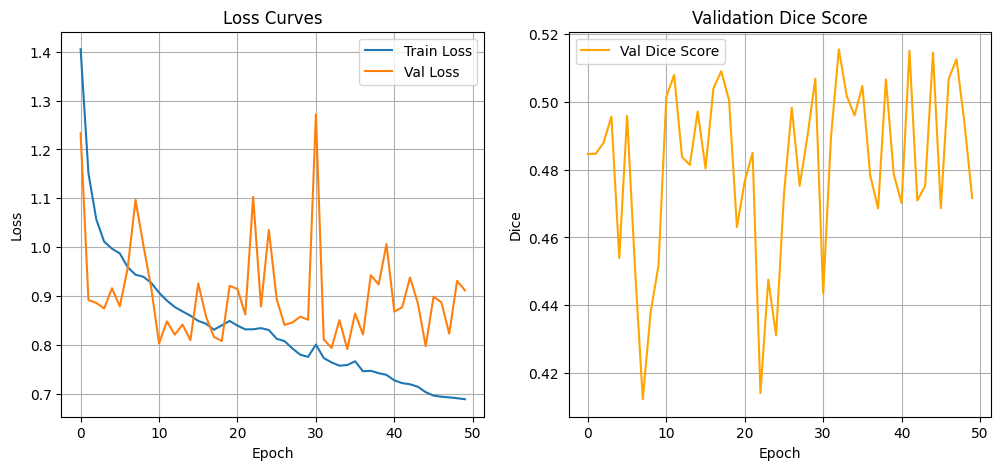

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score

print("--- Starting Full Training Run (300 Epochs) ---")

# 1. Setup
num_epochs = 50
learning_rate = 1e-3
crop_size = 256

# Re-initialize model to ensure fresh weightprocs
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, 
    drop_rate=0.1
).to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-2)
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5)

# Tracking
train_losses = []
val_losses = []
val_dices = []

best_val_loss = float('inf')
save_path = "best_cellvit_model.pth"

# 2. Training Loop
for epoch in range(num_epochs):
    # --- Training ---
    decoder.train()
    running_loss = 0.0
    steps = 0
    
    # Use the feeder to iterate through training tissues
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        pss = data_dict['pss'].to(device)
        mask = data_dict['mask'].to(device).long()
        
        optimizer.zero_grad()
        outputs = decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
        
        # Cleanup to save memory
        del pss, mask, outputs, pred_logits, loss
    
    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)
    
    # --- Validation ---
    decoder.eval()
    val_running_loss = 0.0
    val_running_dice = 0.0
    val_steps = 0
    
    with torch.no_grad():
        for i, data_dict in enumerate(feeder.iterate_image_orion(val_tids, crop_size=crop_size)):
            pss = data_dict['pss'].to(device)
            mask = data_dict['mask'].to(device).long()
            
            outputs = decoder(pss)
            pred_logits = outputs['nuclei_type_map']
            
            loss = criterion(pred_logits, mask)
            val_running_loss += loss.item()
            
            pred_mask = torch.argmax(pred_logits, dim=1)
            dice = calculate_dice_score(pred_mask, mask, num_classes)
            val_running_dice += dice
            
            val_steps += 1
            
            del pss, mask, outputs, pred_logits, loss, pred_mask
    
    avg_val_loss = val_running_loss / val_steps if val_steps > 0 else 0
    avg_val_dice = val_running_dice / val_steps if val_steps > 0 else 0
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    # Print progress every epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
    
    # Save Best Model
    if avg_val_dice > best_val_dice:  # Note the '>' sign (Higher is better)
        best_val_dice = avg_val_dice
        torch.save(decoder.state_dict(), "best_cellvit_dice_model.pth")
        print(f"  --> New Best Dice: {best_val_dice:.4f}")

print("Training Complete.")

# 3. Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title('Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.show()

### Training 2

Second run

In [7]:
import os
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from src.models.cellvit_decoder import CellViTDecoder
from src.utils.cellvit_utils import CombinedLoss, calculate_dice_score

print("--- Starting Refined Training Run (Scheduler + Dice Saving) ---")

# 1. SETUP
num_epochs = 100  # Increased because Scheduler needs time to work
learning_rate = 1e-3
crop_size = 256

# --- CHANGE 1: Create Checkpoints Directory ---
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, "best_cellvit_dice.pth")

# Re-initialize model
decoder = CellViTDecoder(
    num_nuclei_classes=num_classes,
    embed_dim=512, 
    drop_rate=0.1
).to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=1e-2)
criterion = CombinedLoss(num_classes=num_classes, alpha=0.5)

# --- CHANGE 2: Add Learning Rate Scheduler ---
# If Validation Loss doesn't go down for 5 epochs, cut LR by half (factor=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Tracking
train_losses = []
val_losses = []
val_dices = []

# --- CHANGE 3: Track Best Dice, not Loss ---
best_val_dice = 0.0

# 2. TRAINING LOOP
for epoch in range(num_epochs):
    # --- Training Phase ---
    decoder.train()
    running_loss = 0.0
    steps = 0
    
    for i, data_dict in enumerate(feeder.iterate_image_orion(train_tids, crop_size=crop_size)):
        pss = data_dict['pss'].to(device)
        mask = data_dict['mask'].to(device).long()
        
        optimizer.zero_grad()
        outputs = decoder(pss)
        pred_logits = outputs['nuclei_type_map']
        
        loss = criterion(pred_logits, mask)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
        
        del pss, mask, outputs, pred_logits, loss
    
    avg_train_loss = running_loss / steps if steps > 0 else 0
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    decoder.eval()
    val_running_loss = 0.0
    val_running_dice = 0.0
    val_steps = 0
    
    with torch.no_grad():
        for i, data_dict in enumerate(feeder.iterate_image_orion(val_tids, crop_size=crop_size)):
            pss = data_dict['pss'].to(device)
            mask = data_dict['mask'].to(device).long()
            
            outputs = decoder(pss)
            pred_logits = outputs['nuclei_type_map']
            
            loss = criterion(pred_logits, mask)
            val_running_loss += loss.item()
            
            pred_mask = torch.argmax(pred_logits, dim=1)
            dice = calculate_dice_score(pred_mask, mask, num_classes)
            val_running_dice += dice
            
            val_steps += 1
            
            del pss, mask, outputs, pred_logits, loss, pred_mask
    
    avg_val_loss = val_running_loss / val_steps if val_steps > 0 else 0
    avg_val_dice = val_running_dice / val_steps if val_steps > 0 else 0
    
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    # --- CHANGE 4: Step the Scheduler ---
    # We tell the scheduler what the current loss is. 
    # If it's stuck, the scheduler will lower the LR automatically.
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")
    
    # --- CHANGE 5: Save strictly on Best Dice ---
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(decoder.state_dict(), save_path)
        print(f"  --> 🌟 New Best Dice: {best_val_dice:.4f} (Saved to {save_path})")

print("Training Complete.")

# 3. Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves (With Scheduler)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title(f'Validation Dice Score (Best: {best_val_dice:.4f})')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.show()

--- Starting Refined Training Run (Scheduler + Dice Saving) ---


/opt/conda/envs/tissuevit/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 